## Advanced ML: Домашнее задание 2 - Староверова Таисия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tournaments_raw_path = "/content/drive/MyDrive/Colab Notebooks/tournaments.pkl"
tournaments_raw = pd.DataFrame.from_dict((pd.read_pickle(tournaments_raw_path))).T

players_raw_path = "/content/drive/MyDrive/Colab Notebooks/players.pkl"
players_raw = pd.DataFrame.from_dict(pd.read_pickle(players_raw_path)).T

results_raw_path = "/content/drive/MyDrive/Colab Notebooks/results.pkl"
results_dict = pd.read_pickle(results_raw_path)

In [4]:
# players_raw = pd.DataFrame.from_dict(pd.read_pickle(r'players.pkl')).T
# results_dict = pd.read_pickle(r'results.pkl')
# tournaments_raw = pd.DataFrame.from_dict((pd.read_pickle(r'tournaments.pkl'))).T

## Обработка данных

* прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl)
* взять в тренировочный набор турниры с dateStart из 2019 года
* в тестовый — турниры с dateStart из 2020 года


In [5]:
rows = []
for tournament, value in list(results_dict.items()):
    for team in value:
        try:
            if team['mask'] is not None:
                row = {'tournament_id': tournament,'team_name':None, 'team_id':None, 'team_mask':None, 'team_position':None, 'team_questions_total':None,
                      'player_id':None, 'player_name':None, 'player_patronymic':None, 'player_surname':None,
                      'player_rating':None, 'player_used_rating':None,}
                row['team_name'] = team['team']['name']
                row['team_id'] = team['team']['id']
                row['team_mask'] = team['mask']
                row['team_position'] = team['position']
                row['team_questions_total'] = team['questionsTotal']
                for member in team['teamMembers']:
                    player_row = row.copy()
                    player_row['player_id'] = member['player']['id']
                    player_row['player_name'] = member['player']['name']
                    player_row['player_patronymic'] = member['player']['patronymic']
                    player_row['player_surname'] = member['player']['surname']
                    player_row['player_rating'] = member['rating']
                    player_row['player_used_rating'] = member['usedRating']
                    rows.append(player_row)
        except:
            continue


In [6]:
len(rows)

2331587

In [7]:
results_raw = pd.DataFrame(rows)
results_raw.head(3)

tournament_id  team_name  team_id  \
0             22  Неспроста        1   
1             22  Неспроста        1   
2             22  Неспроста        1   

                                           team_mask  team_position  \
0  0111011101101110001101110011111111110011111100...            1.0   
1  0111011101101110001101110011111111110011111100...            1.0   
2  0111011101101110001101110011111111110011111100...            1.0   

   team_questions_total  player_id player_name player_patronymic  \
0                    67       1560     Евгений      Наполеонович   
1                    67       2935    Анатолий        Рафаилович   
2                    67       3270        Юрий        Германович   

  player_surname  player_rating  player_used_rating  
0       Арутюнов              0                   0  
1         Белкин              0                   0  
2     Бершидский              0                   0

In [8]:
players_raw.head(3)

id     name patronymic    surname
1    1  Алексей       None   Абабилов
10  10    Игорь                Абалов
11  11  Наталья    Юрьевна  Абалымова

In [9]:
tournaments_type = pd.json_normalize(tournaments_raw['type'])
tournaments_type = tournaments_type.rename(columns={"id": "tournament_type_id", "name": "tournament_type_name"})

tournaments = pd.concat([tournaments_raw.drop('type', axis=1), tournaments_type], axis=1)
tournaments = tournaments[tournaments['id'].notnull()]
tournaments['tournament_type_id'] = tournaments['tournament_type_id'].fillna(0)

tournaments = tournaments.loc[tournaments['tournament_type_name'].isin(('Обычный', 'Синхрон', 'Строго синхронный'))]
tournaments.head()

id                                name                  dateStart  \
1  1            Чемпионат Южного Кавказа  2003-07-25T00:00:00+04:00   
2  2                         Летние зори  2003-08-09T00:00:00+04:00   
3  3                    Турнир в Ижевске  2003-11-22T00:00:00+03:00   
4  4  Чемпионат Украины. Переходной этап  2003-10-11T00:00:00+04:00   
5  5                 Бостонское чаепитие  2003-10-10T00:00:00+04:00   

                     dateEnd      season orgcommittee synchData questionQty  \
1  2003-07-27T00:00:00+04:00  /seasons/1           []      None        None   
2  2003-08-09T00:00:00+04:00  /seasons/1           []      None        None   
3  2003-11-24T00:00:00+03:00  /seasons/2           []      None        None   
4  2003-10-12T00:00:00+04:00  /seasons/2           []      None        None   
5  2003-10-13T00:00:00+04:00  /seasons/2           []      None        None   

   tournament_type_id tournament_type_name  
1                 2.0              Обычный  
2                 2.0              Обычный  
3                 2.0              Обычный  
4                 2.0              Обычный  
5                 2.0              Обычный

In [10]:
tournaments_train = tournaments[tournaments['dateStart'].str.startswith('2019')]
tournaments_test = tournaments[tournaments['dateStart'].str.startswith('2020')]

## Baseline-модель рейтинг-листа игроков

* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


Представим данные в формате игрок - вопрос - ответ, где ответ всей команды считается ответом игрока.

In [11]:
columns_of_interest = ['player_id','tournament_id','team_mask']
full_train_df = tournaments_train.merge(results_raw, left_on='id', right_on='tournament_id', how='inner')
full_test_df = tournaments_test.merge(results_raw, left_on='id', right_on='tournament_id', how='inner')
train_df = full_train_df[columns_of_interest]
test_df = full_test_df[columns_of_interest]

In [12]:
all_questions_cnt = 0
question_to_tournament = {}
tournament_to_questions = {}

for t_id in sorted(train_df['tournament_id'].unique()):
    tournament_num_questions = 0
    mask_length = 0
    for (idx, player, mask) in train_df.loc[train_df['tournament_id']==t_id,['player_id', 'team_mask']].itertuples():
        mask_length = max(len(mask), mask_length)
    questions_range = range(all_questions_cnt, all_questions_cnt + mask_length)
    tournament_to_questions[t_id] = questions_range
    all_questions_cnt += mask_length
    
    for q in questions_range:
        question_to_tournament[q] = t_id

In [13]:
def get_players_answers(row):
    questions_indices = list(tournament_to_questions[row['tournament_id']])
    mask = row['team_mask']
    answers = [0 if i=='0' else 1 for i in mask]

    players_answers = np.empty((len(mask), 3))
    players_answers[:, 0] = row['player_id']
    players_answers[:, 1] = questions_indices[:len(mask)]
    players_answers[:, 2] = answers
    return players_answers

players_to_questions = train_df.apply(get_players_answers, axis=1)
players_to_questions = pd.DataFrame(list(players_to_questions.explode()), columns=['player_id', 'question_id', 'y']).astype(int)

players_to_questions.head()

player_id  question_id  y
0       6212            0  1
1       6212            1  1
2       6212            2  1
3       6212            3  1
4       6212            4  1

In [14]:
players_to_questions['y'].value_counts()

0    3190460
1    2385920
Name: y, dtype: int64

In [15]:
full_train_df["mask_len"] = full_train_df["team_mask"].apply(len)
players_stats = full_train_df.groupby("player_id").agg(tournaments_played = ("tournament_id", "count"),
                                                       total_answered_questions = ("team_questions_total", sum),
                                                        total_questions = ("mask_len", sum))
players_stats["answers_ratio"] = players_stats.apply(lambda row: row["total_answered_questions"] / row["total_questions"], axis=1)
players_stats.head()

tournaments_played  total_answered_questions  total_questions  \
player_id                                                                  
15                          4                        69              144   
23                          1                        18               36   
31                          4                        76              156   
38                          3                        19              129   
47                          7                       144              273   

           answers_ratio  
player_id                 
15              0.479167  
23              0.500000  
31              0.487179  
38              0.147287  
47              0.527473

Будем обучать лог регрессию на линейной комбинации навыка игрока и простоты вопроса.

In [16]:
max_player_id = players_stats.index.max()
players_indices = torch.tensor(players_to_questions.player_id.values, dtype=torch.long)
questions_indices = torch.tensor(players_to_questions.question_id.values, dtype=torch.long)
labels = torch.tensor(players_to_questions.y, dtype=torch.float)

In [17]:
class LR_W_Weights(torch.nn.Module):
    def __init__(self, player_weights=None, question_weights=None):
        super(LR_W_Weights, self).__init__()
        self.player = torch.nn.Linear(max_player_id + 1, 1, bias=False)
        if player_weights:
            self.linear.weight[:, 0] = player_weights
            
        self.questions = torch.nn.Linear(all_questions_cnt, 1, bias=False)
        if question_weights:
            self.questions.weight[:, 0] = question_weights
        
    def forward(self, players_indices, questions_indices):
        player_coeffs = self.player.weight[0, players_indices]
        question_coeffs = self.questions.weight[0, questions_indices]
        result = player_coeffs + question_coeffs 
        
        return torch.sigmoid(result)

In [18]:
def train_w_weights(epochs=100):
    loss_history = []
    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        y_pred = model(players_indices, questions_indices).squeeze(0)
        loss = criterion(y_pred, labels)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

    plt.title('Train loss')
    plt.plot(range(len(loss_history)), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return loss_history

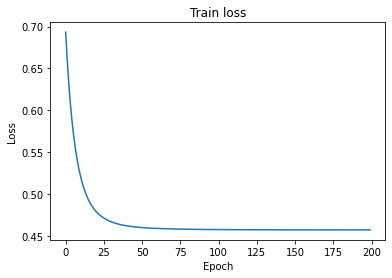

In [19]:
model = LR_W_Weights()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

loss_history = train_w_weights(epochs = 200)

Топ-15 игроков:

In [20]:
player_to_weight_dict = {}
for p in players_stats.index.values:
    player_to_weight_dict[p] = model.player.weight.detach().cpu()[0][p].item()

In [21]:
player_to_weight_sorted = pd.DataFrame(sorted(player_to_weight_dict.items(), key = lambda x: x[1], reverse = True), columns =["id", "player_weight"])
player_to_weight_sorted = player_to_weight_sorted.merge(players_raw, on='id', how='inner')
player_to_weight_sorted.head(15)

id  player_weight        name     patronymic       surname
0   19060       3.872916   Александр  Александрович    Людикайнен
1   26798       3.872847        Анна    Григорьевна     Резникова
2   30260       3.377669     Евгений       Павлович       Спектор
3   27403       2.873200      Максим     Михайлович         Руссо
4    4270       2.853072  Александра   Владимировна        Брутер
5   37047       2.750591       Мария     Алексеевна         Юнгер
6   27822       2.662158      Михаил   Владимирович     Савченков
7   28751       2.642976        Иван     Николаевич       Семушин
8   26089       2.639034       Ирина      Сергеевна    Прокофьева
9   15727       2.606244   Александр    Геннадьевич  Коробейников
10  18036       2.590741      Михаил          Ильич  Левандовский
11  40411       2.537374     Дмитрий      Сергеевич       Кудинов
12  22799       2.501912      Сергей       Игоревич     Николенко
13  20691       2.432765   Станислав    Григорьевич   Мереминский
14  22935       2.425862        Илья      Сергеевич       Новиков

Оценка результатов будущих турниров:

In [22]:
test_df_w_player_weights = full_test_df[['tournament_id','name','team_id','team_name','player_id','team_position']].merge(
    player_to_weight_sorted, left_on='player_id', right_on='id', how='left')
test_df_w_player_weights['player_weight'] = test_df_w_player_weights['player_weight'].fillna(
    test_df_w_player_weights.groupby(['tournament_id','team_id'])['player_weight'].transform('mean'))
test_df_w_player_weights['player_weight'] = test_df_w_player_weights['player_weight'].fillna(
    test_df_w_player_weights.groupby(['tournament_id'])['player_weight'].transform('mean'))
test_df_w_player_weights.head(3)

tournament_id              name_x  team_id        team_name player_id  \
0           4957  Синхрон Биркиркары    49804  Борский корабел     30152   
1           4957  Синхрон Биркиркары    49804  Борский корабел     30270   
2           4957  Синхрон Биркиркары    49804  Борский корабел     27822   

   team_position     id  player_weight  name_y    patronymic    surname  
0            1.0  30152       2.405081   Артём     Сергеевич   Сорожкин  
1            1.0  30270       2.394741  Сергей    Леонидович    Спешков  
2            1.0  27822       2.662158  Михаил  Владимирович  Савченков

In [23]:
test_team_ratings_df = test_df_w_player_weights.groupby(['tournament_id','team_id'])['player_weight'].mean().reset_index()
test_team_ratings_df = test_team_ratings_df.rename(columns={"player_weight": "mean_team_weight"})
test_team_ratings_df["predicted_team_rank"] = test_team_ratings_df.groupby(['tournament_id'])["mean_team_weight"].rank(method="average", ascending=False)
test_team_ratings_df = test_team_ratings_df.merge(test_df_w_player_weights[["tournament_id", "team_id", "team_position"]].drop_duplicates(), 
                                                    on=["tournament_id", "team_id"], how="inner")
test_team_ratings_df.head(3)

tournament_id  team_id  mean_team_weight  predicted_team_rank  \
0           4957        2          1.910463                  5.0   
1           4957       84          0.819172                 44.0   
2           4957      312          0.902036                 39.0   

   team_position  
0            5.5  
1           31.5  
2           47.0

In [24]:
from scipy.stats import spearmanr, kendalltau

sp_test = spearmanr(test_team_ratings_df["team_position"], test_team_ratings_df["predicted_team_rank"]).correlation
kd_test = kendalltau(test_team_ratings_df["team_position"], test_team_ratings_df["predicted_team_rank"]).correlation

(sp_test, kd_test)

(0.8068040816055949, 0.6269187517248309)

Топ-15 самых сложных турниров

In [25]:
question_to_weight_dict = {}
for q in range(all_questions_cnt):
    question_to_weight_dict[q] = model.questions.weight.detach().cpu()[0][q].item()

In [26]:
tournaments_questions_df = pd.DataFrame(pd.DataFrame.from_dict(tournament_to_questions,orient='index').T.unstack().dropna()
    .reset_index(level=1,drop=True))
tournaments_questions_df['tournament_id'] = tournaments_questions_df.index
tournaments_questions_df = tournaments_questions_df.rename(columns={0: "question_id"})
tournaments_questions_df.reset_index(drop=True)

question_id  tournament_id
0             0.0           4772
1             1.0           4772
2             2.0           4772
3             3.0           4772
4             4.0           4772
...           ...            ...
9696       9696.0           5527
9697       9697.0           5527
9698       9698.0           5527
9699       9699.0           5527
9700       9700.0           5527

[9701 rows x 2 columns]

In [27]:
tournaments_difficulty = pd.DataFrame.from_dict(question_to_weight_dict, orient='index').reset_index()
tournaments_difficulty = tournaments_difficulty.rename(columns={'index':'question_id', 0:'question_weight'})
tournaments_difficulty = tournaments_difficulty.merge(tournaments_questions_df, on='question_id', how='inner')
tournaments_difficulty = pd.DataFrame(tournaments_difficulty.groupby(['tournament_id'])['question_weight'].mean().reset_index())
tournaments_difficulty = tournaments_difficulty.merge(full_train_df[['tournament_id','name']].drop_duplicates(), on='tournament_id', how='left')
tournaments_difficulty.sort_values(by=['question_weight']).head(15)

tournament_id  question_weight  \
35            5159        -2.381274   
21            5083        -2.059377   
192           5515        -2.034077   
11            5025        -2.005100   
151           5465        -1.978145   
125           5427        -1.912813   
181           5501        -1.835469   
36            5161        -1.806132   
41            5186        -1.790844   
23            5098        -1.722235   
59            5303        -1.699432   
115           5412        -1.617908   
117           5415        -1.609865   
91            5384        -1.538076   
174           5492        -1.336452   

                                                  name  
35                        Первенство правого полушария  
21                                   Ускользающая сова  
192            Чемпионат Минска. Лига А. Тур четвёртый  
11                                       Кубок городов  
151                                   Чемпионат России  
125                                             День D  
181                                     Кубок Кайнозоя  
36                                           Антибинго  
41                    VERSUS: Коробейников vs. Матвеев  
23                  Ра-II: синхрон "Борского корабела"  
59                        Мемориал Дмитрия Коноваленко  
115                      Серия Premier. Седьмая печать  
117  Главные вопросы жизни, вселенной и всего таког...  
91                                     Поволжская лига  
174                   Кубок соседней галактики. Дельта

## EM-алгоритм

* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


In [28]:
def get_teams_answers(row):
    questions_indices = list(tournament_to_questions[row['tournament_id']])
    mask = row['team_mask']
    answers = [0 if i=='0' else 1 for i in mask]

    teams_answers = np.empty((len(mask), 4))
    teams_answers[:, 0] = row['tournament_id']
    teams_answers[:, 1] = row['team_id']
    teams_answers[:, 2] = questions_indices[:len(mask)]
    teams_answers[:, 3] = answers
    return teams_answers

teams_to_questions = full_train_df.apply(get_teams_answers, axis=1)
teams_to_questions = pd.DataFrame(list(teams_to_questions.explode()), columns=['tournament_id', 'team_id', 'question_id', 'y']).astype(int)

teams_to_questions.head()

tournament_id  team_id  question_id  y
0           4772    45556            0  1
1           4772    45556            1  1
2           4772    45556            2  1
3           4772    45556            3  1
4           4772    45556            4  1

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
answered_mask = teams_to_questions['y'] == 1
unanswered_mask = ~answered_mask

EPS = 10e-10
Z_initial = np.full((teams_to_questions.shape[0],), EPS)
Z_initial[answered_mask] = 1 - EPS
Z = Z_initial
Z = np.log(Z / (1 - Z))

In [31]:
def e_step(Z, Z_new):
    Z_updated = np.ones(Z.shape, dtype=np.float)
    Z_updated[answered_mask] = Z[answered_mask]
    Z_updated[unanswered_mask] = Z_new[unanswered_mask]
    return Z_updated

def m_step(X, Z):
    model = LinearRegression().fit(X, Z)
    preds = model.predict(X)
    return model, preds

In [34]:
team_to_players = full_train_df.groupby(['tournament_id', 'team_id'])['player_id'].apply(list).reset_index()
team_to_players.head(3)

tournament_id  team_id                                        player_id
0           4772      299                  [8610, 96417, 8455, 475, 19170]
1           4772      336                [3645, 8044, 33099, 27691, 23150]
2           4772      338  [123416, 123385, 10493, 123386, 123415, 183347]

In [ ]:
num_unique_combinations = teams_to_questions[['tournament_id', 'team_id', 'question_id']].drop_duplicates().size
all_players = players_stats.index.values
X = np.zeros((num_unique_combinations, len(all_players)))
X.shape

for idx, row in teams_to_questions.iterrows():
    if row['y'] == 1:
        players = team_to_players.loc[(team_to_players['tournament_id']==row['tournament_id']) & (team_to_players['team_id']==row['team_id']), ['player_id']]['player_id']
        X[idx, players] = 1

In [34]:
tol = 10e-2
n = 5
models = []
for i in range(n):
    model, preds = m_step(X, Z)
    Z_new = e_step(Z, preds)
    if np.abs(Z - Z_new) < tol:
            break
    Z = Z_new
    labels = torch.sigmoid(Z_new)
    models.append(model)

NameError: ignored